# MIGHT example on Wise-1 cancer data

## Import libraries and local functions

In [8]:
# dependency libararies
import warnings
import pickle
import time
import numpy as np
import pandas as pd

# treeple functions
from treeple.ensemble import HonestForestClassifier
from treeple.tree import ObliqueDecisionTreeClassifier
from treeple.stats import build_oob_forest

warnings.filterwarnings("ignore")

In [9]:
# local function for processing cancer data files
def get_X_y(f, root="./data/", cohort=[], verbose=False):
    df = pd.read_csv(root + f)
    non_features = [
        "Run",
        "Sample",
        "Library",
        "Cancer Status",
        "Tumor type",
        "Stage",
        "Library volume (uL)",
        "Library Volume",
        "UIDs Used",
        "Experiment",
        "P7",
        "P7 Primer",
        "MAF",
    ]
    sample_ids = df["Sample"]
    # if sample is contains "Run" column, remove it
    for i, sample_id in enumerate(sample_ids):
        if "." in sample_id:
            sample_ids[i] = sample_id.split(".")[1]
    target = "Cancer Status"
    y = df[target]
    # convert the labels to 0 and 1
    y = y.replace("Healthy", 0)
    y = y.replace("Cancer", 1)
    # remove the non-feature columns if they exist
    for col in non_features:
        if col in df.columns:
            df = df.drop(col, axis=1)
    nan_cols = df.isnull().all(axis=0).to_numpy()
    # drop the columns with all nan values
    df = df.loc[:, ~nan_cols]
    # if cohort is not None, filter the samples
    if cohort is not None:
        # filter the rows with cohort1 samples
        X = df[sample_ids.isin(cohort)]
        y = y[sample_ids.isin(cohort)]
    else:
        X = df
    if "Wise" in f:
        # replace nans with zero
        X = X.fillna(0)
    # impute the nan values with the mean of the column
    X = X.fillna(X.mean(axis=0))
    # check if there are nan values
    # nan_rows = X.isnull().any(axis=1)
    nan_cols = X.isnull().all(axis=0)
    # remove the columns with all nan values
    X = X.loc[:, ~nan_cols]
    if verbose:
        if nan_cols.sum() > 0:
            print(f)
            print(f"nan_cols: {nan_cols.sum()}")
            print(f"X shape: {X.shape}, y shape: {y.shape}")
        else:
            print(f)
            print(f"X shape: {X.shape}, y shape: {y.shape}")
    # X = X.dropna()
    # y = y.drop(nan_rows.index)

    return X, y

## Process the Wise-1 cancer data

In [3]:
DIRECTORY = "./"
N_JOBS = 4
N_EST = 100 # 100_000

# collect sample data
sample_list_file = DIRECTORY + "AllSamples.MIGHT.Passed.samples.txt"
sample_list = pd.read_csv(sample_list_file, sep=" ", header=None)
sample_list.columns = ["library", "sample_id", "cohort"]

# get the sample ids for specific cohorts
cohort1 = sample_list[sample_list["cohort"] == "Cohort1"]["sample_id"]
cohort2 = sample_list[sample_list["cohort"] == "Cohort2"]["sample_id"]
PON = sample_list[sample_list["cohort"] == "PanelOfNormals"]["sample_id"]

In [4]:
# obtain the samples for cohort 1
X, y = get_X_y("WiseCondorX.Wise-1.csv.gz", root=DIRECTORY, cohort=cohort1)

# Save the processed data to a CSV file for use in the Yggdrasil notebook
processed_data = X.copy()
processed_data["Cancer Status"] = y
processed_data.to_csv("processed_wise1_data.csv", index=False)

In [5]:
X.shape

(352, 2523)

## Run axis-aligned MIGHT

In [41]:
est = HonestForestClassifier(
    n_estimators=N_EST,
    max_samples=1.6,
    max_features=0.3,
    bootstrap=True,
    stratify=True,
    n_jobs=N_JOBS,
    random_state=23,
    honest_prior="ignore",
    honest_method='prune',
)

# record start time
start_time = time.perf_counter()

# obtain tree level posteriors
fitted_est, tree_proba = build_oob_forest(est, X, y)

# calculate fitting time
end_time = time.perf_counter()
time_dif = end_time-start_time

print(time_dif)

1.2514145409986668


In [42]:
# obtain forest level posteriors
forest_proba = np.nanmean(tree_proba, axis=0)

## Or run oblique MIGHT

In [3]:
# dependency libararies
import warnings
import pickle
import time
import numpy as np
import pandas as pd

# treeple functions
from treeple.ensemble import HonestForestClassifier
from treeple.tree import ObliqueDecisionTreeClassifier
from treeple.stats import build_oob_forest

warnings.filterwarnings("ignore")

In [4]:
est = HonestForestClassifier(
    n_estimators=1000,
    max_samples=1.0, # Use all samples for bootstrapping. Use 1.0 instead of 1. 1 means literally 1 sample
    max_features=160, # Keep this static
    bootstrap=True,
    stratify=True,
    n_jobs=-1, # Use all resources
    random_state=42,
    honest_prior="ignore",
    honest_method='prune',
    tree_estimator=ObliqueDecisionTreeClassifier(),
    max_depth = None, # Fully grow trees
    n_threads = 96
)

# # record start time
# start_time = time.perf_counter()

# # obtain tree level posteriors
# fitted_est, tree_proba = build_oob_forest(est, X, y)

# # calculate fitting time
# end_time = time.perf_counter()
# time_dif = end_time-start_time

# print(time_dif)

## Benchmarks


(n=1000, d=160):
  train_time mean=10.1425s, std=0.0351
  inference_time mean=1.1848s, std=0.0156
  accuracy mean=0.513, std=0.003

(n=1000, d=320):
  train_time mean=10.2620s, std=0.0538
  inference_time mean=1.7522s, std=0.0202
  accuracy mean=0.503, std=0.026

(n=1000, d=640):
  train_time mean=10.4505s, std=0.0718
  inference_time mean=2.8507s, std=0.0201
  accuracy mean=0.490, std=0.024

(n=1000, d=1024):
  train_time mean=10.7079s, std=0.0606
  inference_time mean=4.1683s, std=0.0188
  accuracy mean=0.492, std=0.006

(n=1000, d=2048):
  train_time mean=11.5363s, std=0.0318
  inference_time mean=7.6124s, std=0.0374
  accuracy mean=0.510, std=0.012

(n=1000, d=4096):
  train_time mean=16.9053s, std=0.0418
  inference_time mean=14.4957s, std=0.0072
  accuracy mean=0.501, std=0.027

(n=1000, d=8192):
  train_time mean=38.5697s, std=1.3277
  inference_time mean=28.7006s, std=0.2347
  accuracy mean=0.513, std=0.007

(n=2000, d=160):
  train_time mean=15.6750s, std=0.1406
  inference_t

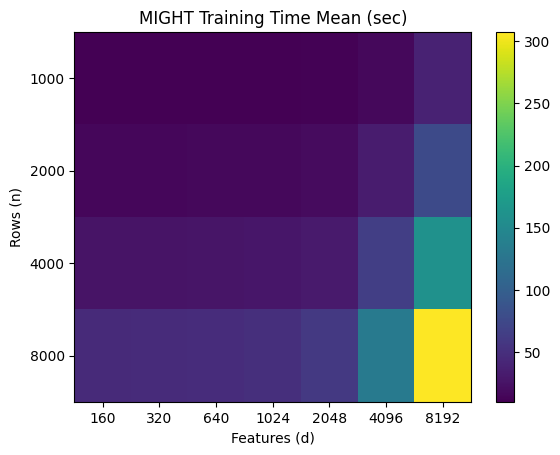

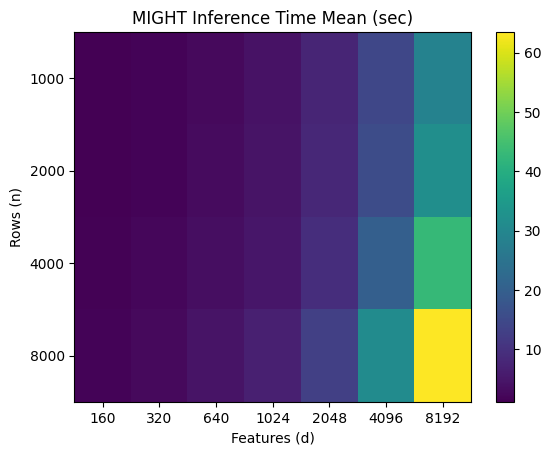

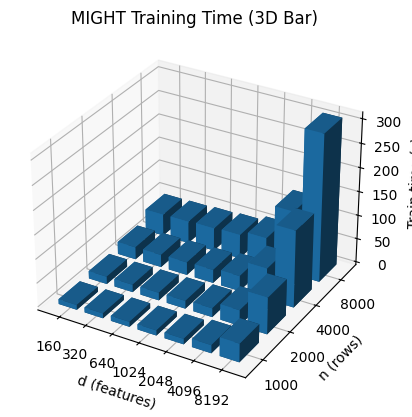

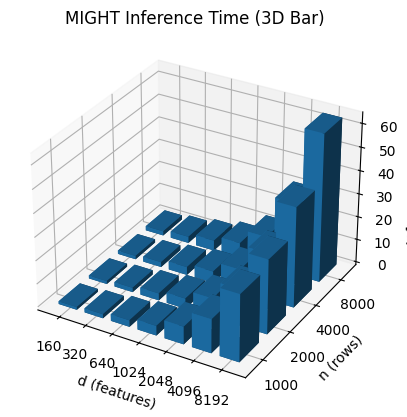

In [11]:
##############################################
# MIGHT Benchmark with Repeats & 3D Plot
##############################################

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# MIGHT / treeple
from treeple.ensemble import HonestForestClassifier
from treeple.tree import ObliqueDecisionTreeClassifier
from treeple.stats import build_oob_forest


def plot_3d_bars(pivot_df, title="3D Bar Plot", zlabel="Runtime (s)"):
    """
    Plots a 3D bar chart from a pivot table DataFrame where:
      - pivot_df.index = array of n-values
      - pivot_df.columns = array of d-values
      - pivot_df.values = numeric quantity (runtime, etc.)
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    n_values = pivot_df.index.to_numpy()
    d_values = pivot_df.columns.to_numpy()

    n_indices = np.arange(len(n_values))
    d_indices = np.arange(len(d_values))

    bar_width = 0.7
    xs = []
    ys = []
    dzs = []

    for i, n_val in enumerate(n_values):
        for j, d_val in enumerate(d_values):
            xs.append(j)                      # x = index of d
            ys.append(i)                      # y = index of n
            dzs.append(pivot_df.iloc[i, j])   # the cell value

    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.zeros_like(xs)  # bars start at z=0
    dx = bar_width * np.ones_like(xs)
    dy = bar_width * np.ones_like(xs)
    dz = np.array(dzs)

    ax.bar3d(xs, ys, zs, dx, dy, dz)

    ax.set_title(title)
    ax.set_xlabel("d (features)")
    ax.set_ylabel("n (rows)")
    ax.set_zlabel(zlabel)

    # Ticks: integer positions, labeled by actual n and d
    ax.set_xticks(d_indices + bar_width / 2)
    ax.set_xticklabels(d_values)

    ax.set_yticks(n_indices + bar_width / 2)
    ax.set_yticklabels(n_values)

    plt.show()


def benchmark_might(n_vals, d_vals, repeats=7, random_state=42):
    """
    Benchmarks MIGHT's training & inference time across multiple (n, d) data sizes,
    repeating each (n,d) `repeats` times to compute mean & std dev.

    Returns a DataFrame with columns:
      ["n", "d",
       "train_time_mean", "train_time_std",
       "inference_time_mean", "inference_time_std",
       "accuracy_mean", "accuracy_std"]
    """
    np.random.seed(random_state)
    results = []

    for n in n_vals:
        for d in d_vals:
            train_times = []
            inference_times = []
            accuracies = []

            for _ in range(repeats):
                # 1) Generate random data
                X = np.random.randn(n, d)
                y = np.random.randint(2, size=n)

                # 2) Split
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.3, random_state=random_state, stratify=y
                )

                # 3) Convert to DataFrame
                df_train = pd.DataFrame(X_train)
                df_test  = pd.DataFrame(X_test)

                # 4) Build classifier
                # est = HonestForestClassifier(
                #     n_estimators=50,
                #     max_samples=1.0,
                #     max_features=0.3, # TODO Ariel what is this? We want this a fixed integer, not a ratio
                #     bootstrap=True,
                #     stratify=True,
                #     n_jobs=-1,
                #     random_state=random_state,
                #     honest_prior="ignore",
                #     honest_method="prune",
                #     tree_estimator=ObliqueDecisionTreeClassifier()
                # )
                global est

                # 5) Training time
                t0 = time.perf_counter()
                fitted_est, tree_proba = build_oob_forest(est, df_train, y_train)
                t1 = time.perf_counter()
                train_times.append(t1 - t0)

                # 6) Inference time
                t2 = time.perf_counter()
                test_tree_proba = []
                for tree in fitted_est.estimators_:
                    p = tree.predict_proba(df_test)  # shape (len(X_test), 2)
                    test_tree_proba.append(p)
                test_tree_proba = np.stack(test_tree_proba, axis=0)
                avg_proba = test_tree_proba.mean(axis=0)
                y_proba_test = avg_proba[:, 1]
                y_pred_test = (y_proba_test >= 0.5).astype(int)
                t3 = time.perf_counter()
                inference_times.append(t3 - t2)

                # 7) Accuracy
                acc = accuracy_score(y_test, y_pred_test)
                accuracies.append(acc)

            # Mean/std
            train_time_mean = np.mean(train_times)
            train_time_std  = np.std(train_times)
            inf_time_mean   = np.mean(inference_times)
            inf_time_std    = np.std(inference_times)
            acc_mean        = np.mean(accuracies)
            acc_std         = np.std(accuracies)

            print(f"\n(n={n}, d={d}):")
            print(f"  train_time mean={train_time_mean:.4f}s, std={train_time_std:.4f}")
            print(f"  inference_time mean={inf_time_mean:.4f}s, std={inf_time_std:.4f}")
            print(f"  accuracy mean={acc_mean:.3f}, std={acc_std:.3f}")

            results.append({
                "n": n,
                "d": d,
                "train_time_mean": train_time_mean,
                "train_time_std": train_time_std,
                "inference_time_mean": inf_time_mean,
                "inference_time_std": inf_time_std,
                "accuracy_mean": acc_mean,
                "accuracy_std": acc_std,
            })

    return pd.DataFrame(results)


if __name__ == "__main__":
    # Example grid
    n_values = [1000, 2000, 4000, 8000]
    d_values = [160, 320, 640, 1024, 2048, 4096, 8192]

    df_bench = benchmark_might(n_values, d_values, repeats=3, random_state=42)

    print("\n=== MIGHT Benchmark Results (Averaged Over Repeats) ===")
    print(df_bench)

    # Build pivot tables for train & inference means
    pivot_train = df_bench.pivot(index="n", columns="d", values="train_time_mean")
    pivot_infer = df_bench.pivot(index="n", columns="d", values="inference_time_mean")

    # ---- 1) Heatmap: Training Time
    plt.figure()
    plt.imshow(pivot_train, aspect="auto")
    plt.colorbar()
    plt.title("MIGHT Training Time Mean (sec)")
    plt.xticks(range(len(d_values)), d_values)
    plt.yticks(range(len(n_values)), n_values)
    plt.xlabel("Features (d)")
    plt.ylabel("Rows (n)")
    plt.show()

    # ---- 2) Heatmap: Inference Time
    plt.figure()
    plt.imshow(pivot_infer, aspect="auto")
    plt.colorbar()
    plt.title("MIGHT Inference Time Mean (sec)")
    plt.xticks(range(len(d_values)), d_values)
    plt.yticks(range(len(n_values)), n_values)
    plt.xlabel("Features (d)")
    plt.ylabel("Rows (n)")
    plt.show()

    # ---- 3) 3D "Cityscape" for Training Time
    plot_3d_bars(
        pivot_train,
        title="MIGHT Training Time (3D Bar)",
        zlabel="Train time (s)"
    )

    # ---- 4) 3D "Cityscape" for Inference Time
    plot_3d_bars(
        pivot_infer,
        title="MIGHT Inference Time (3D Bar)",
        zlabel="Inference time (s)"
    )


- [ ] Comparable YDF trees to MIGHT? MIGHT code is being ran right? Why is 0.5 probability?
- [ ] Try on a Intel machine
    - Focus on Training Time. Focus on YDF.
- [ ] Scale up to overwhelm cache size
- [ ] Figure out why accuracy is a coin flip



Hi Randal,

The corresponding parameters to set in ydf are:
```
    bootstrap_size_ratio = max_samples
    num_candidate_attributes_ratio = max_features
    random_seed = random_state
    num_threads = n_jobs
```

max_samples=1.6 is based on our attempt to give more samples to each tree in the forest, and max_samples>1.0 would not be available in other forest learners. I couldn't find stratification parameters in ydf, so that's only in treeple, too. max_features=0.3 does represent 0.3 of features to consider during splitting. It is a conventional number (another one is square root of the number of features), so we can set that for both forests.

So, to make the comparison fair, after excluding the parts ydf couldn't do, we recommend using these 2 setups:

treeple_model = HonestForestClassifier(
    n_estimators=1000,
    max_samples=1.0,
    max_features=0.3,
    bootstrap=True,
    n_jobs=N_JOBS,
    random_state=23,
    honest_prior="ignore",
    tree_estimator=ObliqueDecisionTreeClassifier(),
)

ydf_model = ydf.RandomForestLearner(
    label="Cancer Status",
    split_axis="SPARSE_OBLIQUE",
    num_trees=1000, 
    max_depth=-1,  
    honest=True,
    bootstrap_training_dataset=True
    bootstrap_size_ratio=1.0,
    num_threads=N_JOBS,
    num_candidate_attributes_ratio=0.3,
    random_seed=23,
)

They should have close matching parameters for comparisons. Please let us know if you have other questions. Thank you.